<h2><center> <font color=grey>Weight Data Cleaning Algorithm - </font> <font color=#F36E31>Version 2</font> </center></h2>
<font color=#474747><center> <font color=#F36E31>Metabolic </font>( Weight Management ) </center></font>
<font color=#474747><center> Team - Data Science | April 2023 - May 2023 |  By -   Sofia & Paritosh</center></font>




<font color= #F36E31> **1. BUSINESS PROBLEM**</font>

<img src="static_files/business_problem.png" alt="Image Title" style="display:block; margin-left:auto; margin-right:auto; margin-top:auto; margin-bottom:auto;max-width:800px;">

- <font color=#474747> For Weight Management , Dario smart scale and app do not currently support the ability to differentiate weight measurements for multiple users sharing the same scale.</font>

- <font color=#474747> The weight data is currently not reliable due to these limitations, resulting in our inability to deliver accurate and reliable reports, monitor weight progress and make informed decisions based on it.</font>





<font color= #F36E31> **2. PROBLEM STATEMENT**</font>

<font color=#474747>In order to get reliable data,</font>
- <font color=#474747>Detect and Mark the weight measurements as valid or invalid.</font>
- <font color=#474747>Detect Other unusual patterns and anomalies.</font>
- <font color=#474747>Detect whether multiple users are using same scale and map the measurements to the identified users.</font>



<font color=#F36E31> **Version 1.0 :** </font>

- <font color =#474747>In Version 1.0,</font>

    - <font color=#474747>We attempted a purely <font color=#F36E31>statistical approach</font> to detect invalid measurements.</font>
    
    - <font color=#474747> We also employed machine learning algorithms, such as clustering, to identify multiple users and group their measurements.</font>
    
    - <font color=#474747>Additionally, we implemented a few other logics to identify unusual patterns.</font>


- <font color=#474747>All considered weight thresholds, including the lower weight limit, upper weight limit, and weight fluctuations, are based on analysis.</font>


- <font color=#474747>Important Sources/Links</font>

    - <font color=#474747>Confluence Page - [Anomaly Detection in Weight Measurements](https://dariosw.atlassian.net/l/cp/G13A5c8v) | Airflow GitHub - [data-airflow/dags/weight_management_ad](https://github.com/myDario/data-airflow/tree/main/dags/weight_management_ad)</font>




<font color=#F36E31> **Version 2.0 :** </font>

<font color=#474747>Version 2.0 is a rule based cleaning algorithm,  mainly involves a combination of business logics and clinical approaches.</font>

- <font color=#474747>In this version,</font>
    - <font color=#474747>The weight data cleaning is primarily focused for a single user.</font>
    
    - <font color=#474747>The primary user among the multiple users has been identified based on the first reference weight shared by the users.</font>
    
    <img src="static_files/‎profile_page.png" alt="Profile Page" style="display:block; margin-left:auto; margin-right:auto; margin-top:auto; margin-bottom:auto;max-width:800px;">

    - <font color=#474747>Considering the first reference weight as the weight shared by the primary user, first valid weight is selected.</font>
    
    - <font color=#474747> Using the first valid weight as a reference, we compare percentage changes within a specific gap for each new weight entry. Based on whether the changes fall within clinically acceptable ranges, valid or invalid weights are marked.</font>
    






<h4><font color=#F36E31>3. DATA DESCRIPTION</font></h4>

- <font color=#474747>Important Tables - <font color=#3585ae>Snowflake</font> :</font>
    - <font color=#4747467>PHI_DB.BKND_SEARCHSTAT.EVENT_WEIGHTCHANGEEVENT:
        - Weight measurements data of the users.</font>
    
    - <font color=#4747467>DWH.REPORTS.b2b2c_eligiblity:
        - For B2B users' information.</font>
    
    - <font color=#4747467>PHI_DB.BKND_SEARCHSTAT.EVENT_STATICDATACHANGEEVENT:
        - Reference weight data updated on the profile page. Confluence Page : [Version 4.3.0 Static Data](https://dariosw.atlassian.net/l/cp/a9kXMAUK)</font>
    
    



<h4><font color=#F36E31>4. EVALUATION / PERFORMANCE METRIC</font></h4>

- <font color=#474747>Required : Accuracy and Confusion Matrix</font> 

    <font color=#474747>Due to the unavailability of a labeled dataset, the performance of the algorithm has been evaluated manually.</font>
    
    
- <font color=#474747> Source: Tableau Report ( Prepared after evaluation ) - [weight_data_cleaning_algorithm_v2.3](https://reports.dariocare.com/#/workbooks/325)</font>






<h4><font color=#F36E31>5. BUSINESS CONSTRAINTS</font></h4>

- <font color=#474747> Users with less than 5 measurements should not be considered.</font>
- <font color=#474747> Only smart scale measurements should be considered.</font>
- <font color=#474747> ≥ 90% Cleaned Users are required.</font>

- <font color=#474747>Excessive cleaning or removing weight measurements can result in the loss of activity data, making it difficult to track weight progress and potentially leading to billing issues.</font>

- <font color=#474747>Selection of first valid weight is important. This can be directly used as a baseline weight for PG Analysis.</font>



<h4><font color=#F36E31>6. IMPLEMENTATION</font></h4>

<h4><font color=#F36E31>6.1 IMPORTING REQUIRED MODULES</font></h4>

In [1]:
# For Data Wrangling
import pandas as pd
import numpy as np
from datetime import timedelta

# For Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# To Fetch Data from Snowflake
import snowflake.connector 

import json 
import sys
import time
import logging
import warnings 
warnings.filterwarnings('ignore')

# Checking Versions
print("Python version:", sys.version_info.major, ".", sys.version_info.minor, ".", sys.version_info.micro)
print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)
print("Seaborn version:", sns.__version__)
print("Matplotlib version:", matplotlib.__version__)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__) 

Python version: 3 . 8 . 0
Pandas version: 1.3.4
NumPy version: 1.21.4
Seaborn version: 0.11.2
Matplotlib version: 3.5.0


In [2]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [5]:
cd ..

/Users/Paritosh.Mahto/Desktop/anomaly_detection_v2


<h4><font color=#F36E31>6.2 EXPORTING DATA FROM SNOWFLAKE BY EXECUTING QUERIES.</font></h4>

In [6]:
with open("scripts/config/snowflake_credentials.json", 'r') as json_file:
    conns = json.load(json_file)

In [7]:
conns['SnowflakeDB']["UserName"] = 'paritosh.mahto@wayforward.io'
conns['SnowflakeDB']["Password"] = 'Ryspeh-reggoq-wumci2'

In [8]:
connection = snowflake.connector.connect( 
    user=conns['SnowflakeDB']['UserName'],
    password=conns['SnowflakeDB']['Password'],
    account=conns['SnowflakeDB']['Host'],
    warehouse = conns["SnowflakeDB"]["Warehouse"]
)

INFO:snowflake.connector.connection:Snowflake Connector for Python Version: 2.9.0, Python Version: 3.8.0, Platform: macOS-10.16-x86_64-i386-64bit
INFO:snowflake.connector.connection:This connection is in OCSP Fail Open Mode. TLS Certificates would be checked for validity and revocation status. Any other Certificate Revocation related exceptions or OCSP Responder failures would be disregarded in favor of connectivity.
INFO:snowflake.connector.connection:Setting use_openssl_only mode to False


In [9]:
# For Reference Weight

sql_1 = """ 

SELECT
    s.UID,
    s.DEVICEUTC,
    s.VALUE,
    s.PROPERTYID
FROM
    "PHI_DB"."BKND_SEARCHSTAT"."EVENT_STATICDATACHANGEEVENT" s
JOIN
    "PHI_DB"."BKND_SEARCHSTAT"."EVENT_WEIGHTCHANGEEVENT" w
    ON s.UID = w.UID
WHERE
    s.PROPERTYID = 'fwgt'
    AND s.UID IS NOT NULL
GROUP BY
    s.UID, s.DEVICEUTC, s.VALUE, s.PROPERTYID
ORDER BY
    s.UID;
"""

data_static = pd.read_sql_query(sql_1, con=connection, dtype={'VALUE': float})

INFO:snowflake.connector.cursor:query: [SELECT s.UID, s.DEVICEUTC, s.VALUE, s.PROPERTYID FROM "PHI_DB"."BKND_SEARCHSTAT"...]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.cursor:Number of results in first chunk: 3480


In [11]:
# checking data types
data_static.dtypes

UID                    int64
DEVICEUTC     datetime64[ns]
VALUE                float64
PROPERTYID            object
dtype: object

In [12]:
# Weight Measurements Data

sql_2 = """
--  Data Preparation for Weight Data Cleaning Algorithm 2023-06-28 
    -- The objective is to optimize the data preprocessing steps.
    
-- Mapping GROUP_NAME 
WITH WEIGHT_EVENT_WITH_GROUP_NAME AS (
    SELECT
        WEIGHT_EVENT.ID,
        WEIGHT_EVENT.UID,
        WEIGHT_EVENT.TRANSACTION_ID,
        WEIGHT_EVENT.METADATA,
        WEIGHT_EVENT.DEVICEUTC,
        WEIGHT_EVENT.WEIGHTVALUE,
        B2B2C_ELIGIBILITY.GROUP_NAME
    FROM
        "PHI_DB"."BKND_SEARCHSTAT"."EVENT_WEIGHTCHANGEEVENT" AS WEIGHT_EVENT
    LEFT JOIN (
        SELECT
            UID,
            GROUP_NAME,
            ROW_NUMBER() OVER (PARTITION BY UID ORDER BY GROUP_NAME) AS ROW_NUM
        FROM
            "DWH"."REPORTS"."b2b2c_eligiblity"
    ) AS B2B2C_ELIGIBILITY ON WEIGHT_EVENT.UID = B2B2C_ELIGIBILITY.UID
        AND B2B2C_ELIGIBILITY.ROW_NUM = 1
),

--  Measurements Count per user
ID_COUNT_PER_USER AS (
    SELECT
        UID,
        COUNT(DISTINCT ID) AS MEASUREMENT_COUNT
    FROM
        "PHI_DB"."BKND_SEARCHSTAT"."EVENT_WEIGHTCHANGEEVENT"
    GROUP BY
        UID
)

-- Final Aggregation and transformation
SELECT 
    t1.ID,
    t1.UID,
    t1.TRANSACTION_ID,
    t1.DEVICEUTC,
    t1.WEIGHTVALUE,
    t1.GROUP_NAME,
    CASE WHEN t1.GROUP_NAME IS NULL THEN 'B2C' ELSE 'B2B' END AS CLIENT_TYPE,
    CASE WHEN t1.METADATA IS NULL THEN 'manually_inserted' ELSE 'smart_scale' END AS MEASUREMENT_TYPE,
    CASE WHEN t2.MEASUREMENT_COUNT < 5 THEN TRUE ELSE FALSE END AS COUNT_LESS_THAN_5,
    CASE WHEN t2.MEASUREMENT_COUNT > 5000 THEN TRUE ELSE FALSE END AS COUNT_MORE_THAN_5000,
    CASE WHEN (t1.GROUP_NAME = 'union_pacific' AND t1.WEIGHTVALUE NOT BETWEEN 10 AND 300) OR t1.WEIGHTVALUE NOT BETWEEN 40 AND 300 THEN TRUE ELSE FALSE END AS WEIGHT_NOT_WITHIN_RANGE,
    DATEDIFF(DAY, (SELECT MIN(DEVICEUTC) FROM WEIGHT_EVENT_WITH_GROUP_NAME WHERE UID = t1.UID), t1.DEVICEUTC) AS USAGE_DAY,
    FLOOR(DATEDIFF(DAY, (SELECT MIN(DEVICEUTC) FROM WEIGHT_EVENT_WITH_GROUP_NAME WHERE UID = t1.UID), t1.DEVICEUTC) / 30) AS USAGE_MONTH
FROM
    WEIGHT_EVENT_WITH_GROUP_NAME t1
    LEFT JOIN ID_COUNT_PER_USER t2 ON t1.UID = t2.UID ORDER BY UID, DEVICEUTC;
"""
data_raw = pd.read_sql_query(sql_2, con=connection)

INFO:snowflake.connector.cursor:query: [--  Data Preparation for Weight Data Cleaning Algorithm 2023-06-28 -- The object...]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.cursor:Number of results in first chunk: 1519


In [13]:
print("    -  Data Considered Till -  \n" )

print("EVENT_STATICDATACHANGEEVENT:", data_static['DEVICEUTC'].max(), '\n')

print("EVENT_WEIGHTCHANGEEVENT:" , data_raw['DEVICEUTC'].max())

    -  Data Considered Till -  

EVENT_STATICDATACHANGEEVENT: 2023-07-18 07:29:56 

EVENT_WEIGHTCHANGEEVENT: 2023-07-18 07:29:56


In [14]:
# Serializing SQL Query in .sql file
filename = "scripts/sql_query/data_preparation_query.sql"

with open(filename, "w") as file:
    file.write(sql_2)

-----

<h4><font color=#F36E31>6.3 REFERENCE WEIGHT FIX</font></h4>

- <font color=#474747> Since, self-shared weight values are frequently updated by the users and we don't have previously shared weights as these are overwritten in this table ```PHI_DB.BKND_SEARCHSTAT.EVENT_STATICDATACHANGEEVENT```  instability in the results have been observed.</font>
- <font color=#474747>Cases when reference weights are updated:

- When:
  - User set weight in intake
  - User update weight in profile page
  - Upon registration if a user entered weight (some Enrollment flows)</font>


- <font color=#474747> In order to fix the instability issue, this function has been created.</font>


In [15]:
def reference_data_fix(updated_data, previous_data_filepath):
    """
    Returns a dataframe with the required reference weight.

    Argument(s):
    updated_data: Latest data from "PHI_DB"."BKND_SEARCHSTAT"."EVENT_STATICDATACHANGEEVENT"
    previous_data_filepath: File path of the previously saved data.
    """
    start_time = time.time()
    with open(previous_data_filepath) as json_file:
        previous_data = pd.read_json(json_file, orient='split', dtype={'DEVICEUTC': 'datetime64'})

    concatenated_data = pd.concat([updated_data, previous_data], axis=0)
    concatenated_data = concatenated_data.sort_values(by=['UID', 'DEVICEUTC']).reset_index(drop=True)
    concatenated_data_wo_duplicates = concatenated_data.drop_duplicates(subset=['UID', 'DEVICEUTC']).sort_values(by='UID')

    condition = concatenated_data_wo_duplicates.groupby('UID')['DEVICEUTC'].idxmin()
    required_reference_weight = concatenated_data_wo_duplicates.loc[condition]

    concatenated_data_wo_duplicates['DEVICEUTC'] = concatenated_data_wo_duplicates['DEVICEUTC'].astype('str')
    df_json = concatenated_data_wo_duplicates.to_json(orient="split", index=False)

    with open(previous_data_filepath, 'w') as json_file_updated:
        json_file_updated.write(df_json)

    elapsed_time = time.time() - start_time
    logger.info(f"Time taken to execute reference_data_fix: {round(elapsed_time, 2)} secs")
    return required_reference_weight

In [16]:
filepath = 'scripts/static_files/data_reference_wht.json'
required_ref_wht = reference_data_fix(data_static, previous_data_filepath=filepath)

INFO:__main__:Time taken to execute reference_data_fix: 3.74 secs


In [17]:
print(required_ref_wht.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75834 entries, 0 to 165098
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   UID         75834 non-null  int64         
 1   DEVICEUTC   75834 non-null  datetime64[ns]
 2   VALUE       75830 non-null  float64       
 3   PROPERTYID  75834 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 2.9+ MB
None


- There can be null reference weight values.

---
<h4><font color=#F36E31>6.4 DATA PREPARATION</font></h4>


In [18]:
def invalid_reference_weight_check(reference_weight):
    """
    Returns a list of UIDs whose reference weight is less than the lower weight limit or NULL or 0.
    
    Argument(s):
    reference_weight: Dataframe with Group Name and Reference Weight
    """
    uid_null = reference_weight[(reference_weight['REFERENCE_WEIGHT'] == 0) | (reference_weight['REFERENCE_WEIGHT'].isnull())]['UID'].to_list()

    reference_weight = reference_weight.dropna(subset=['REFERENCE_WEIGHT'])
    reference_weight = reference_weight[reference_weight['REFERENCE_WEIGHT'] != 0]

    df_grouped = reference_weight.groupby('UID').first().reset_index()
    filtered_df = df_grouped[
        (df_grouped['GROUP_NAME'] == 'union_pacific') & (df_grouped['REFERENCE_WEIGHT'].astype(float) <= 10) |
        (df_grouped['GROUP_NAME'] != 'union_pacific') & (df_grouped['REFERENCE_WEIGHT'].astype(float) <= 40)
    ]
    uid_lt_lower_limit = filtered_df['UID'].tolist()

    uid_list = uid_lt_lower_limit + uid_null

    return uid_list

In [19]:
def data_preparation(reference_weight_df, weight_measurements_df):
    """
    Return four dataframes and one list
    
    Argument(s):
    reference_weight_df: Dataframe with first reference weight of the user.
    weight_measurements_df: Raw weight measurements data fetched from snowflake.
    """
    start_time = time.time()
    
    weight_measurements_df = weight_measurements_df.merge(reference_weight_df[['UID', 'VALUE']], on='UID', how='left')
    weight_measurements_df = weight_measurements_df.rename(columns={'VALUE':'REFERENCE_WEIGHT'})
    
    weight_measurements_less_than_5 = weight_measurements_df[weight_measurements_df['COUNT_LESS_THAN_5'] == True].reset_index(drop=True)
    weight_measurements_more_than_5000 = weight_measurements_df[weight_measurements_df['COUNT_MORE_THAN_5000'] == True].reset_index(drop=True)
    weight_measurements_valid = weight_measurements_df[(weight_measurements_df['COUNT_LESS_THAN_5'] == False) & (weight_measurements_df['COUNT_MORE_THAN_5000'] == False)].reset_index(drop=True)

    weight_measurements_valid['ABS_DIFF'] = np.abs(weight_measurements_valid['WEIGHTVALUE'].astype(float) - weight_measurements_valid['REFERENCE_WEIGHT'].astype(float))

    condition_1 = (weight_measurements_valid['MEASUREMENT_TYPE'] == 'smart_scale')
    condition_2 = (weight_measurements_valid["WEIGHT_NOT_WITHIN_RANGE"] == False)

    valid_measurements_filtered_1 = weight_measurements_valid.loc[condition_1]
    valid_measurements_filtered_2 = valid_measurements_filtered_1.loc[condition_2].reset_index(drop=True)

    invalid_reference_weight_uids = invalid_reference_weight_check(valid_measurements_filtered_2)

    elapsed_time = time.time() - start_time
    logger.info(f"\nTime taken to perform data_preparation: {round(elapsed_time, 2)} secs")

    return weight_measurements_less_than_5, weight_measurements_valid, weight_measurements_more_than_5000, valid_measurements_filtered_2, invalid_reference_weight_uids


In [21]:
( user_w_less_than_5_measures,
        valid_users_measures,
        user_w_more_than_5000_measures,
        valid_measurements_filtered_2,
        invalid_reference_weight_uids,
    ) = data_preparation(reference_weight_df=required_ref_wht, weight_measurements_df=data_raw) 

INFO:__main__:
Time taken to perform data_preparation: 1.01 secs


In [22]:
valid_users_measures.columns

Index(['ID', 'UID', 'TRANSACTION_ID', 'DEVICEUTC', 'WEIGHTVALUE', 'GROUP_NAME',
       'CLIENT_TYPE', 'MEASUREMENT_TYPE', 'COUNT_LESS_THAN_5',
       'COUNT_MORE_THAN_5000', 'WEIGHT_NOT_WITHIN_RANGE', 'USAGE_DAY',
       'USAGE_MONTH', 'REFERENCE_WEIGHT', 'ABS_DIFF'],
      dtype='object')

---
<h4><font color=#F36E31>6.4 SELECTION OF FIRST VALID WEIGHT [ Weight closest to the Reference Weight ]</font></h4>


In [25]:
def lower_limit_wht_fix(filtered_data, first_valid_weight, uid_list):
    """
    Returns a dataframe with fixed first valid weight
    
    Argument(s):
    filtered_data: Filtered dataframe with valid weights only.
    first_valid_weight: Dataframe with first valid weight in user with reference weight needs to be fixed.
    uid_list: Users whose reference weight is less than lower weight limit.
    """
    columns = ['ID', 'UID', 'GROUP_NAME', 'DEVICEUTC', 'WEIGHTVALUE', 'REFERENCE_WEIGHT', 'ABS_DIFF']
    
    filtered_data = filtered_data[filtered_data['UID'].isin(uid_list)]
    first_valid_weight = first_valid_weight[~first_valid_weight['UID'].isin(uid_list)][columns]
    
    first_day_df = filtered_data.loc[filtered_data.groupby('UID')['USAGE_DAY'].idxmin()][columns]
    first_valid_weight_fixed = first_day_df.loc[first_day_df.groupby('UID')['WEIGHTVALUE'].idxmax()]
    
    first_valid_weight = pd.concat([first_valid_weight, first_valid_weight_fixed], ignore_index=True)
    
    return first_valid_weight

<font color=#F36E31>APPROACH-1</font>

- <font color=#474747> Out of first five weights , weight which is closest to the Reference Weight will be considered as **First Valid Weight**.</font>


In [26]:
def first_valid_weight_selection_using_approach_1(filtered_data, uid_list):
    """
    Returns a dataframe with first valid weight using approach - 1.
    
    Argument(s):
    filtered_data: Filtered dataframe with valid weights only.
    uid_list: Users whose reference weight is less than lower weight limit.
    """
    start_time = time.time()
    
    filtered_data = filtered_data.sort_values(by=['UID', 'DEVICEUTC']).reset_index(drop=True)
    filtered_data['MEASURES'] = filtered_data.groupby('UID').cumcount() + 1
    
    filtered_data_less_than_5 = filtered_data[filtered_data['MEASURES'] <= 5].reset_index(drop=True)
    first_valid_weight = filtered_data_less_than_5.loc[filtered_data_less_than_5.groupby('UID')['ABS_DIFF'].idxmin()]
    
    first_valid_weight_fixed = lower_limit_wht_fix(filtered_data, first_valid_weight, uid_list)
    first_valid_weight_fixed = first_valid_weight_fixed.rename(columns={'WEIGHTVALUE': 'FIRST_VALID_WEIGHT'})
    
    elapsed_time = time.time() - start_time
    logger.info(f"\nTime taken to execute first_valid_weight_selection_using_approach_1: {round(elapsed_time, 2)} secs")
    
    return first_valid_weight_fixed


In [27]:
first_valid_weight_1 = first_valid_weight_selection_using_approach_1(filtered_data=valid_measurements_filtered_2,
                                                                    uid_list=invalid_reference_weight_uids)

INFO:__main__:
Time taken to execute first_valid_weight_selection_using_approach_1: 0.49 secs


In [28]:
first_valid_weight_1.head()

,ID,UID,GROUP_NAME,DEVICEUTC,FIRST_VALID_WEIGHT,REFERENCE_WEIGHT,ABS_DIFF
0,1214893,172,None,2021-06-23 14:25:40,68.23,68.23000,0.00000
1,1201724,18325,None,2021-05-25 20:55:04,70.66,67.00000,3.66000
2,1138800,21711,None,2020-11-26 08:18:30,66.83,67.31311,0.48311
3,1134331,45642,None,2020-11-25 13:44:35,69.11,69.10000,0.01000
4,1182072,56298,None,2021-04-07 12:29:47,130.36,121.18000,9.18000


<font color=#F36E31>APPROACH-2</font>

- <font color=#474747>Out of  first five weights of the first usage month , weight which is closest to the Reference Weight will be considered as **First Valid Weight**.</font>

In [30]:
def first_valid_weight_selection_using_approach_2(filtered_data, uid_list):
    """
    Returns a dataframe with first valid weight using approach - 2.
    
    Argument(s):
    filtered_data: Filtered dataframe with valid weights only.
    uid_list: Users whose reference weight is less than lower weight limit.
    """
    start_time = time.time()
    
    min_usage_month = filtered_data.groupby('UID')['USAGE_MONTH'].min()
    uid_month_map = min_usage_month.to_dict()  
    
    filtered_data_first_valid_month = filtered_data.copy()
    filtered_data_first_valid_month['VALID_MONTH'] = filtered_data_first_valid_month['UID'].map(uid_month_map) == filtered_data_first_valid_month['USAGE_MONTH']

    filtered_data_first_valid_month = filtered_data_first_valid_month[filtered_data_first_valid_month['VALID_MONTH']]

    filtered_data_first_valid_month = filtered_data_first_valid_month.sort_values(by=['UID', 'DEVICEUTC']).reset_index(drop=True)
    filtered_data_first_valid_month['MEASURES'] = filtered_data_first_valid_month.groupby('UID').cumcount() + 1

    filtered_data_less_than_5 = filtered_data_first_valid_month[filtered_data_first_valid_month['MEASURES'] <= 5].reset_index(drop=True)
    
    first_valid_weight = filtered_data_less_than_5.loc[filtered_data_less_than_5.groupby('UID')['ABS_DIFF'].idxmin()]
    
    first_valid_weight_fixed = lower_limit_wht_fix(filtered_data, first_valid_weight, uid_list)
    first_valid_weight_fixed = first_valid_weight_fixed.rename(columns={'WEIGHTVALUE': 'FIRST_VALID_WEIGHT'})
   
    elapsed_time = time.time() - start_time
    logger.info(f"\nTime taken to execute first_valid_weight_selection_using_approach_2: {round(elapsed_time, 2)} secs")
    
    return first_valid_weight_fixed


In [31]:
first_valid_weight_2 = first_valid_weight_selection_using_approach_2( filtered_data=valid_measurements_filtered_2, 
                                                                     uid_list=invalid_reference_weight_uids)

INFO:__main__:
Time taken to execute first_valid_weight_selection_using_approach_2: 0.29 secs


In [32]:
first_valid_weight_2.head()

,ID,UID,GROUP_NAME,DEVICEUTC,FIRST_VALID_WEIGHT,REFERENCE_WEIGHT,ABS_DIFF
0,1214893,172,None,2021-06-23 14:25:40,68.23,68.23000,0.00000
1,1201724,18325,None,2021-05-25 20:55:04,70.66,67.00000,3.66000
2,1138800,21711,None,2020-11-26 08:18:30,66.83,67.31311,0.48311
3,1134331,45642,None,2020-11-25 13:44:35,69.11,69.10000,0.01000
4,1182072,56298,None,2021-04-07 12:29:47,130.36,121.18000,9.18000



<font color=#F36E31>APPROACH-3</font>

   - <font color=#474747> Without considering days gap, 
        1. Consider the first five days' measurements.
        2. Calculate the median weight for each day.
        3. Identify the day with the median weight closest to the reference weight.
        4. Choose the weight measurement closest to the median weight of the selected day as the **First Valid Weight**.</font>


In [34]:
def first_valid_weight_selection_using_approach_3(filtered_data, agg_func, uid_list):
    """
    Returns a dataframe with first valid weight using approach-3.
    
    Argument(s):
    filtered_data: Filtered dataframe with valid weights only.
    agg_func: Aggregation function to use for aggregating weight values (e.g., 'mean', 'median').
    uid_list: Users whose reference weight is less than lower weight limit.
    """
    start_time = time.time()
    
    filtered_data_1 = filtered_data.copy()
    reference_wht = filtered_data.groupby('UID')['REFERENCE_WEIGHT'].first().reset_index()
    
    aggregated_data = filtered_data.groupby(['UID', 'USAGE_DAY'])['WEIGHTVALUE'].agg(AGG_VAL=agg_func).reset_index()
    first_5_days_data = aggregated_data.groupby('UID').head(5).merge(reference_wht, on='UID', how='left')
    first_5_days_data['DIFF'] = np.abs(first_5_days_data['AGG_VAL'] - first_5_days_data['REFERENCE_WEIGHT'].astype(float))
    
    valid_day = first_5_days_data.loc[first_5_days_data.groupby('UID')['DIFF'].idxmin()]
    uid_day_map = valid_day.set_index('UID')['USAGE_DAY'].to_dict()
    
    filtered_data_1['VALID_DAY'] = filtered_data_1.apply(lambda x: x.USAGE_DAY == uid_day_map.get(x.UID), axis=1)
    filtered_data_w_valid_day = filtered_data_1[filtered_data_1['VALID_DAY']]
    filtered_data_w_valid_day = filtered_data_w_valid_day.merge(first_5_days_data[['UID', 'AGG_VAL']], on='UID', how='left')
    filtered_data_w_valid_day['AGG_VAL_DIFF'] = np.abs(filtered_data_w_valid_day['WEIGHTVALUE'] - filtered_data_w_valid_day['AGG_VAL'])
    
    condition = filtered_data_w_valid_day.groupby('UID')['AGG_VAL_DIFF'].idxmin()
    first_valid_weight = filtered_data_w_valid_day.loc[condition]
    first_valid_weight_fixed = lower_limit_wht_fix(filtered_data, first_valid_weight, uid_list)
    first_valid_weight_fixed = first_valid_weight_fixed.rename(columns={'WEIGHTVALUE': 'FIRST_VALID_WEIGHT'})
    
    elapsed_time = time.time() - start_time
    logger.info(f"\nTime taken to execute first_valid_weight_selection_using_approach_3: {round(elapsed_time, 2)} secs")
    
    return first_valid_weight_fixed


In [35]:
first_valid_weight_3 = first_valid_weight_selection_using_approach_3(filtered_data=valid_measurements_filtered_2, agg_func=np.median, uid_list=invalid_reference_weight_uids)

INFO:__main__:
Time taken to execute first_valid_weight_selection_using_approach_3: 13.42 secs


In [36]:
first_valid_weight_3.head()

,ID,UID,GROUP_NAME,DEVICEUTC,FIRST_VALID_WEIGHT,REFERENCE_WEIGHT,ABS_DIFF
0,1214893,172,None,2021-06-23 14:25:40,68.23,68.23000,0.00000
1,1201724,18325,None,2021-05-25 20:55:04,70.66,67.00000,3.66000
2,1134609,21711,None,2020-11-26 08:13:46,68.61,67.31311,1.29689
3,1134331,45642,None,2020-11-25 13:44:35,69.11,69.10000,0.01000
4,1183001,56298,None,2021-04-09 14:34:36,141.31,121.18000,20.13000


---
<h4><font color=#F36E31>6.5 IMPLEMENTING WEIGHT DATA CLEANING LOGIC</font></h4>

In [37]:
# First Check - within a week , if pct_change > 5 %
# then Check - within a month , if pct_change > 10 %
# else check - if pct_change > 20 %

def weight_percent_change_check(df, index, prev_weight, prev_deviceutc, reason_dict):
    """
    Returns a dataframe containing weights which are valid.
    
    Argument(s):
    df: Dataframe containing weight measurements.
    index: Current index being processed.
    prev_weight: Weight value of the previous measurement.
    prev_deviceutc: DEVICEUTC value of the previous measurement.
    reason_dict: Dictionary to store reasons for weight validity.
    """
    if index >= len(df):
        return df, reason_dict

    elif (df.loc[index, 'DEVICEUTC'] - prev_deviceutc <= timedelta(days=7)) and \
            (abs(df.loc[index, 'WEIGHTVALUE'] - prev_weight) / prev_weight > 0.05):
        
        reason_dict[df.loc[index, 'ID']] = f'>_5%_weight_change_within_a_week:prev_valid_weight={prev_weight}kg'
        df = df.drop(index=index).reset_index(drop=True)
        return weight_percent_change_check(df, index, prev_weight, prev_deviceutc, reason_dict)

    elif (df.loc[index, 'DEVICEUTC'] - prev_deviceutc <= timedelta(days=30)) and \
            (abs(df.loc[index, 'WEIGHTVALUE'] - prev_weight) / prev_weight > 0.10):
        
        reason_dict[df.loc[index, 'ID']] = f'>_10%_weight_change_within_a_month:prev_valid_weight={prev_weight}kg'
        df = df.drop(index=index).reset_index(drop=True)
        return weight_percent_change_check(df, index, prev_weight, prev_deviceutc, reason_dict)

    elif abs(df.loc[index, 'WEIGHTVALUE'] - prev_weight) / prev_weight > 0.20:
        reason_dict[df.loc[index, 'ID']] = f'>_20%_weight_change:prev_valid_weight={prev_weight}kg'
        df = df.drop(index=index).reset_index(drop=True)
        return weight_percent_change_check(df, index, prev_weight, prev_deviceutc, reason_dict)

    else:
        df.loc[index, 'ANOMALY'] = False
        reason_dict[df.loc[index, 'ID']] = "no_significant_weight_change_detected"
        return weight_percent_change_check(df, index+1, df.loc[index, 'WEIGHTVALUE'], df.loc[index, 'DEVICEUTC'], reason_dict)


In [38]:
def data_cleaning_for_valid_user(filtered_data, first_valid_weight, weight_measurements_gt_5):
    """
    Returns a dataframe with the final cleaned data.
    
    Argument(s):
    filtered_data: Filtered weight data for valid users.
    first_valid_weight: Dataframe with first valid weight for each user.
    weight_measurements_gt_5: Dataframe with weight measurements greater than 5.
    """
    start_time = time.time()
    reason_dict = {}
    concat_df = pd.DataFrame()
    final_dataframe = weight_measurements_gt_5[weight_measurements_gt_5['UID'].isin(filtered_data['UID'].unique())]
    
    for num, uid in enumerate(set(filtered_data['UID'].unique())):
        measurement_id = 0
        temporary_df = filtered_data[filtered_data['UID'] == uid].reset_index(drop=True)
        
        if temporary_df[temporary_df['WEIGHT_NOT_WITHIN_RANGE'] == False].shape[0] != 0:
            temporary_df = temporary_df[temporary_df['WEIGHT_NOT_WITHIN_RANGE'] == False].reset_index(drop=True)
            measurement_id = first_valid_weight[first_valid_weight['UID'] == uid]['ID'].values[0]
        else:
            measurement_id = first_valid_weight[first_valid_weight['UID'] == uid]['ID'].values[0]  

        temporary_df_sorted = temporary_df[['ID', 'DEVICEUTC', 'WEIGHTVALUE']].sort_values(by=['DEVICEUTC']).reset_index(drop=True)
        temporary_df_sorted = temporary_df_sorted.reset_index()
        first_index = temporary_df_sorted[temporary_df_sorted['ID'] == measurement_id].index.values[0]

        temporary_df_sorted.loc[:, 'ANOMALY'] = True
        temporary_df_sorted.loc[:, 'REASON'] = np.nan
       
        if len(temporary_df_sorted) != 0:
            validated_data, reason_dict = weight_percent_change_check(temporary_df_sorted, first_index, temporary_df_sorted.loc[first_index, 'WEIGHTVALUE'], temporary_df_sorted.loc[first_index, 'DEVICEUTC'], reason_dict)
            temporary_df_sorted.loc[:, 'ANOMALY'] = temporary_df_sorted['index'].apply(lambda x: validated_data[validated_data['index'] == x]['ANOMALY'].values[0] if x in validated_data['index'].values else True)
            temporary_df_sorted.loc[:, 'REASON'] = temporary_df_sorted['ID'].map(reason_dict)
            concat_df = pd.concat([concat_df, temporary_df_sorted], axis=0)
        else:
            concat_df = pd.concat([concat_df, temporary_df_sorted], axis=0)
            
        if num % 1000 == 0:
            print(f"\nProcess completed: {round((num/len(list(filtered_data['UID'].unique()))) * 100, 2)}% done")

    final_validated_data = final_dataframe.merge(concat_df[['ID', 'ANOMALY', 'REASON']], how='left', on='ID')
#     final_validated_data['WEIGHT_VALIDITY_STATUS'] = final_validated_data['ANOMALY'].apply(lambda x: 'valid' if x is False else 'invalid')   
    final_validated_data['WEIGHT_VALIDITY_STATUS'] = np.where(final_validated_data['ANOMALY'], 'invalid', 'valid')
    final_validated_data = final_validated_data.drop(columns='ANOMALY')  
    elapsed_time = time.time() - start_time
    logger.info(f"Time taken to execute data_cleaning_for_valid_user: {round(elapsed_time, 2)} secs")  
    return final_validated_data


In [39]:
data_required = data_cleaning_for_valid_user(filtered_data=valid_measurements_filtered_2,
                                             first_valid_weight=first_valid_weight_1,
                                             weight_measurements_gt_5=valid_users_measures)


Process completed: 0.0% done

Process completed: 23.34% done

Process completed: 46.67% done

Process completed: 70.01% done

Process completed: 93.35% done


INFO:__main__:Time taken to execute data_cleaning_for_valid_user: 825.91 secs


<font color=#F36E31>6.5.1 RE-VALIDATED INITIAL WEIGHTS AFTER FIRST VALID WEIGHT SELECTION.</font>

- <font color=#474747>Check weight change w.r.t reference weight less than | ± 2 | kg.</font>

- <font color=#474747>Kept this as a separate task, so that it can be tuned/modified if the considered fix will not work.</font>

In [46]:
def revalidate_initial_weights(validated_data, first_valid_weight, weight_threshold):
    """
    Returns a DataFrame with re-labelling of initial weights.
    
    Argument(s):
    validated_data: Cleaned DataFrame.
    first_valid_weight: First Valid Weight DataFrame.
    """
    start_time = time.time()
    revalidated_data = validated_data.merge(first_valid_weight[['UID', 'DEVICEUTC']], on=['UID'], how='inner')
    
    revalidated_data = revalidated_data[
        (revalidated_data['MEASUREMENT_TYPE'] == 'smart_scale') &
        (revalidated_data['DEVICEUTC_x'] <= revalidated_data['DEVICEUTC_y']) &
        (revalidated_data['WEIGHT_NOT_WITHIN_RANGE'] == False)
    ]
    revalidated_data = revalidated_data[revalidated_data['WEIGHT_VALIDITY_STATUS'] == 'invalid']
    
    revalidated_data['WEIGHT_VALIDITY_STATUS_AFTER_FIX'] = np.where(
        np.abs(revalidated_data['WEIGHTVALUE'] - revalidated_data['REFERENCE_WEIGHT'].astype(float)) < weight_threshold,
        'valid',
        'invalid'
    )
   
    revalidated_data['REASON_FIX'] = np.where(
        np.abs(revalidated_data['WEIGHTVALUE'] - revalidated_data['REFERENCE_WEIGHT'].astype(float)) < weight_threshold,
        "no_significant_deviation_from_ref_wht",
        "detected_significant_deviation_from_ref_wht"
    )
    
    validated_data = validated_data.merge(revalidated_data[['ID', 'REASON_FIX', 'WEIGHT_VALIDITY_STATUS_AFTER_FIX']], on='ID', how='left')
    validated_data['WEIGHT_VALIDITY_STATUS_AFTER_FIX'] = validated_data['WEIGHT_VALIDITY_STATUS_AFTER_FIX'].fillna(validated_data['WEIGHT_VALIDITY_STATUS'])
    validated_data['REASON_FIX'] = validated_data['REASON'].fillna(validated_data['REASON_FIX'])
    
    elapsed_time = time.time() - start_time
    logger.info(f"\nTime taken to execute revalidate_initial_weights: {round(elapsed_time, 2)} secs")
    return validated_data


In [47]:
revalidated_data = revalidate_initial_weights(data_required, first_valid_weight_1, weight_threshold=2)

INFO:__main__:
Time taken to execute revalidate_initial_weights: 0.73 secs


In [48]:
revalidated_data.head()

,ID,UID,TRANSACTION_ID,DEVICEUTC,WEIGHTVALUE,GROUP_NAME,CLIENT_TYPE,MEASUREMENT_TYPE,COUNT_LESS_THAN_5,COUNT_MORE_THAN_5000,WEIGHT_NOT_WITHIN_RANGE,USAGE_DAY,USAGE_MONTH,REFERENCE_WEIGHT,ABS_DIFF,REASON,WEIGHT_VALIDITY_STATUS,REASON_FIX,WEIGHT_VALIDITY_STATUS_AFTER_FIX
0,1213108,172,61879461,2021-06-20 16:18:59,67.88,None,B2C,smart_scale,False,False,False,0,0,68.23,0.35,NaN,invalid,no_significant_deviation_from_ref_wht,valid
1,1213109,172,61879480,2021-06-20 16:19:43,67.91,None,B2C,smart_scale,False,False,False,0,0,68.23,0.32,NaN,invalid,no_significant_deviation_from_ref_wht,valid
2,1213130,172,61880128,2021-06-20 16:47:45,67.94,None,B2C,smart_scale,False,False,False,0,0,68.23,0.29,NaN,invalid,no_significant_deviation_from_ref_wht,valid
3,1214723,172,61950402,2021-06-22 08:44:15,101.57,None,B2C,smart_scale,False,False,False,2,0,68.23,33.34,NaN,invalid,detected_significant_deviation_from_ref_wht,invalid
4,1214893,172,61955609,2021-06-23 14:25:40,68.23,None,B2C,smart_scale,False,False,False,3,0,68.23,0.00,no_significant_weight_change_detected,valid,no_significant_weight_change_detected,valid


<font color=#F36E31>6.5.2 CREATING FINAL DATAFRAME WITH REQUIRED FEATURES</font>

- <font color=#474747>Added Users with less than 5 Measurements.</font>
- <font color=#474747>Added Users with more than 5000 Measurements.</font>
- <font color=#474747>Users with all measurements are manually shared or all measurements are not in the specified weight ranges.</font>
- <font color=#474747>Update ```REASON``` for the above cases.</font>

In [49]:
def preprocess_and_concatenate_dataframes(df1, df2, df3, df4, first_valid_weight):
    """
    Returns a dataframe with required features.
    
    Argument(s):
    df1: Final dataframe
    df2: Dataframe With Users whose all measurements are invalid
    df3: Dataframe with Users with insufficient data,
    df4:
    """

    start_time = time.time()
    
    # Dataframe with required columns
    df1 = df1.merge(first_valid_weight[['UID', 'FIRST_VALID_WEIGHT']], on='UID', how='left')
    df1 = df1.drop(columns=['REASON', 'WEIGHT_VALIDITY_STATUS'])
    df1 = df1.rename(columns={'REASON_FIX': 'REASON', 
                              'WEIGHT_VALIDITY_STATUS_AFTER_FIX':'WEIGHT_VALIDITY_STATUS'})
    
    c1 = (df1['WEIGHT_NOT_WITHIN_RANGE'] == True)
    c2 = (df1['WEIGHT_NOT_WITHIN_RANGE'] == False)
    c3 = (df1['MEASUREMENT_TYPE'] == 'manually_inserted')
    c4 = (df1['MEASUREMENT_TYPE'] == 'smart_scale')
    
    condition_1 = c1 & c3
    condition_2 = c2 & c3
    condition_3 = c1 & c4
    
    df1.loc[condition_1, 'REASON'] = "manually_inserted_and_not_within_WL_range"
    df1.loc[condition_2, 'REASON'] = "manually_inserted"
    df1.loc[condition_3, 'REASON'] = "not_within_WL_range"
    
    # Dataframe with users whose all measurements are either manually inserted or not within the WL range or both
    df2 = df2[~df2['ID'].isin(df1['ID'].unique())]
    if not df2.empty:
        df2.loc[:, 'REASON'] = "manually_inserted_or_not_within_WL_range_or_both"
        df2.loc[:, 'FIRST_VALID_WEIGHT'] = np.nan
        df2.loc[:, 'WEIGHT_VALIDITY_STATUS'] = 'all_measurements_are_invalid'
     
    # Dataframe with users whose total measurements are less than 5.
    if not df3.empty:
        df3.loc[:, 'REASON'] = '<_5_measurements'
        df3.loc[:, 'FIRST_VALID_WEIGHT'] = np.nan
        df3.loc[:, 'WEIGHT_VALIDITY_STATUS'] = "insufficient_data"
    
    # Dataframe with users whose total measurements are more than 5000.
    if not df4.empty:
        df4.loc[:, 'REASON'] = '>_5000_measurements'
        df4.loc[:, 'FIRST_VALID_WEIGHT'] = np.nan
        df4.loc[:, 'WEIGHT_VALIDITY_STATUS'] = "exceeded_recursion_limit"

    required_columns = ['ID', 'UID', 'TRANSACTION_ID', 'CLIENT_TYPE', 'GROUP_NAME', 'DEVICEUTC',
                        'WEIGHTVALUE', 'MEASUREMENT_TYPE', 'WEIGHT_NOT_WITHIN_RANGE', 'REFERENCE_WEIGHT', 
                        'FIRST_VALID_WEIGHT', 'WEIGHT_VALIDITY_STATUS', 'REASON']
    
    df1 = df1[required_columns]
    if not df2.empty:
        df2 = df2[required_columns]
    if not df3.empty:
        df3 = df3[required_columns]
    if not df4.empty:
        df4 = df4[required_columns]
    
    dataframes = [df1, df2, df3, df4]
    
  
    final_required_data = pd.concat([df for df in dataframes if not df.empty], axis=0).sort_values(by=['ID', 'UID', 'DEVICEUTC'])
    final_required_data['GROUP_NAME'] = final_required_data['GROUP_NAME'].fillna('b2c')
    
    c9 = (final_required_data['MEASUREMENT_TYPE'] == 'manually_inserted')
    c10 =(final_required_data['WEIGHT_VALIDITY_STATUS'] == 'invalid')
    condition_7 = c9 & c10
    final_required_data.loc[condition_7, 'WEIGHT_VALIDITY_STATUS'] = "invalid_manually_inserted"
    final_required_data = final_required_data.reset_index(drop=True)
    
    elapsed_time = time.time() - start_time
    logger.info(f"\nTime taken to execute preprocess_and_concatenate_dataframes: {round(elapsed_time, 2)} secs")
    return final_required_data


In [44]:
dataframe_w_required_features = preprocess_and_concatenate_dataframes(df1=revalidated_data,
                                           df2=valid_users_measures,
                                           df3=user_w_less_than_5_measures,
                                           df4=user_w_more_than_5000_measures,
                                           first_valid_weight=first_valid_weight_1)


INFO:__main__:
Time taken to execute preprocess_and_concatenate_dataframes: 3.1 secs


In [50]:
data_raw = data_raw.sort_values(by=["ID", "UID", "DEVICEUTC"]).reset_index(drop=True)
print('COMPARING ROWS WHETHER THESE ARE SAME AS IN THE RAW DATA:')
print('ID - ', data_raw['ID'].equals(dataframe_w_required_features['ID']))
print('UID - ', data_raw['UID'].equals(dataframe_w_required_features['UID']))
print('DEVICEUTC - ', data_raw['DEVICEUTC'].equals(dataframe_w_required_features['DEVICEUTC']) )  
print('WEIGHTVALUE - ',  data_raw['WEIGHTVALUE'].equals(dataframe_w_required_features['WEIGHTVALUE'])  )    

COMPARING ROWS WHETHER THESE ARE SAME AS IN THE RAW DATA:
ID -  True
UID -  True
DEVICEUTC -  True
WEIGHTVALUE -  True


In [43]:
# save data in csv format
dataframe_w_required_features.to_csv("scripts/static/weight_data_with_required_features.csv", index=False)

---
<h4><font color=#F36E31>6.6 VISUALIZING OUTPUTS</font></h4>

In [51]:
def scatter_plot(df_cleaned_data, sample, plot, col):
    for uid in sample:
        df_filtered = df_cleaned_data[df_cleaned_data['UID'] == uid]
        group_name = df_filtered['GROUP_NAME'].unique()[0]
        ths = df_filtered['FIRST_VALID_WEIGHT'].unique()[0]
        
        ths_1 = df_filtered['REFERENCE_WEIGHT'].unique()[0]
        
        df_filtered_manual = df_filtered[df_filtered['MEASUREMENT_TYPE']
                                         == 'manually_shared']
        plt.figure(figsize=(15, 5))
        
        palette = {'valid': 'green', 'invalid': 'r'}
        
        sns.scatterplot(data=df_filtered, x="DEVICEUTC",
                        y="WEIGHTVALUE", hue=col, palette=palette)
        
        sns.scatterplot(data=df_filtered_manual, x="DEVICEUTC", y="WEIGHTVALUE",
                        marker='s', s=80, color='blue', label='Manually Shared')
        
        plt.axhline(y=ths, linestyle='--', color='r',
                    label='First Valid Weight = ' + str(ths) + 'kg')
        
        plt.axhline(y=ths_1, linestyle='--', color='b',
                    label='Reference Weight = ' + str(ths_1) + 'kg')
        
        plt.axhspan(ths+2, ths-2, alpha=0.1,
                    color='grey', label='+/- 2 kg SPAN')
        
        plt.xlabel("TIME [ YYYY- MM ] ")
        
        plt.ylabel("WEIGHTVALUE")
        
        plt.title('Weight Progress Over Time: UID - ' + str(uid) +' '+ group_name + ' [ REF. WEIGHT = ' + str(
            ths_1) + ' kg ' + ',  FIRST_VALID_WHT = ' + str(ths) + ' kg ]', fontsize=14)
        
        sns.set_style("darkgrid")
        
        plt.legend()
#         plt.savefig("plot_" + str(uid)+plot+ ".png", format="png", dpi=480)
        plt.show()

APPROACH_1


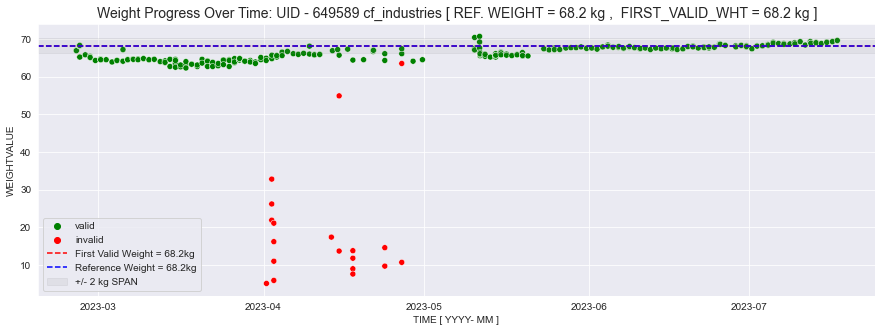

APPROACH_1


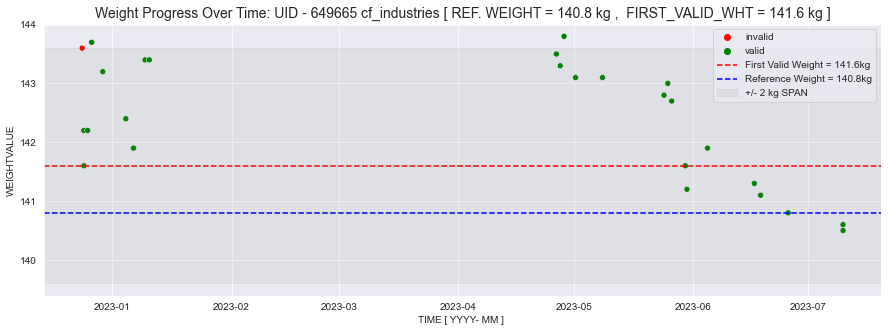

APPROACH_1


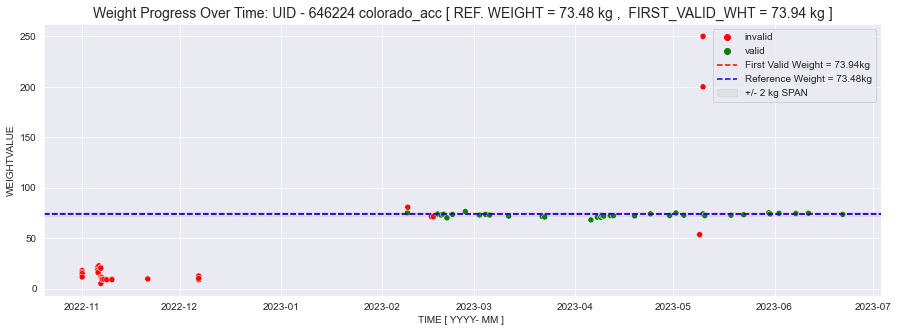

APPROACH_1


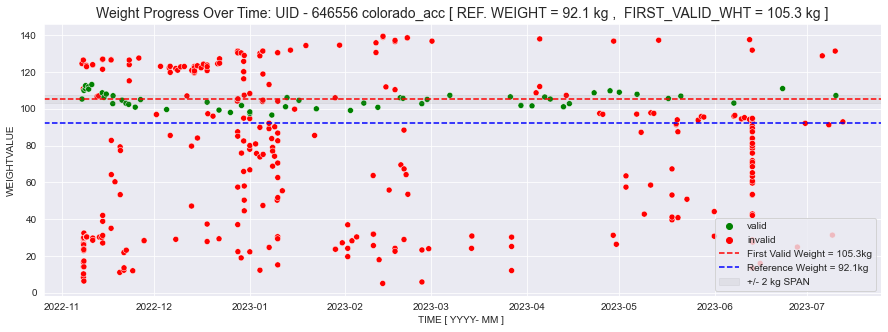

In [53]:
import random 
# uids = list(data_raw['UID].unique())
# sample = random.sample(uids, 5)
for uid in [649589, 649665, 646224, 646556]:
    print("APPROACH_1")
    scatter_plot(dataframe_w_required_features, [uid], 'approach_1', 'WEIGHT_VALIDITY_STATUS')


                                        ------------ END -------------

------

<h4><font color=#F36E31> Creating a configuration file for thresholds and other parameters.</font></h4>

- <font color=#474747>Since Version 2 is a rule-based approach, this configuration file allows for easy customization and adjustment of thresholds and other relevant parameters during the final implementation.</font>

In [54]:
import yaml

configuration = {
    "algorithm": {
        "weight_data_cleaning_algorithm_v2.1": {
            "first_valid_weight_selection": "approach_1",
            "weight_thresholds_in_kg": {
                "lower_weight_limit": 40,
                "upper_weight_limit": 300,
                "lower_weight_limit_union_pacific": 10,
                "weight_recheck_reference_weight": 2
            },
            "weight_percent_change_check": {
                "condition_1_percent_weight_change": 0.05,
                "condition_2_percent_weight_change": 0.10,
                "condition_3_percent_weight_change": 0.20,
                "condition_1_time_threshold": 7,
                "condition_2_time_threshold": 30
            }
        }
    }
}

# Write the YAML config to a file
with open("scripts/config/algorithm_tuning_config.yaml", "w") as config_file:
    yaml.dump(configuration, config_file)


In [56]:
# Reading the config file 
with open("scripts/config/algorithm_tuning_config.yaml", "r") as config_file:
    config_data = yaml.safe_load(config_file)
    
# 
config_data['algorithm']["weight_data_cleaning_algorithm_v2.1"]["first_valid_weight_selection"]== 'approach_1'

True

----
<h4><font color=#F36E31> FINAL DATA CLEANING PIPELINE</font></h4>


In [57]:
def wht_cleaning_pipeline_func(**kwargs):
    global_start_time = time.time()
    
    approach = "approach_1"
    
    start_time = time.time()
    with open('scripts/sql_query/reference_weight.sql', 'r') as query:
        data_static =  pd.read_sql_query(query.read(), con=connection, dtype={'VALUE': float})
    elapsed_time = time.time() - start_time
    logger.info(f"\nTime taken to fetch data_static from the sql: {round(elapsed_time, 2)} secs")
    
    start_time = time.time()
    with open('scripts/sql_query/data_preparation_query.sql', 'r') as query:
        data_raw = pd.read_sql_query(query.read(), con=connection)
    elapsed_time = time.time() - start_time
    logger.info(f"\nTime taken to fetch data_raw from the sql: {round(elapsed_time, 2)} secs")
    
    filepath = 'scripts/static_files/data_reference_wht.json'
    required_ref_wht = reference_data_fix(data_static, previous_data_filepath=filepath)

    # DATA PREPARATION
    user_w_less_than_5_measures, valid_users_measures, user_w_more_than_5000_measures, valid_measurements_filtered_2, invalid_reference_weight_uids = data_preparation(required_ref_wht, data_raw) 
    valid_measurements_filtered_2 = valid_measurements_filtered_2.reset_index(drop=True)


    # PART - I : VALID USER & FIRST VALID MEASUREMENT SELECTION
    if approach is None:
        first_valid_weight = first_valid_weight_selection_using_approach_1(valid_measurements_filtered_2, invalid_reference_weight_uids)
    elif approach == "approach_1":
        first_valid_weight = first_valid_weight_selection_using_approach_1(valid_measurements_filtered_2, invalid_reference_weight_uids)
    elif approach == "approach_2":
        first_valid_weight = first_valid_weight_selection_using_approach_2(valid_measurements_filtered_2, invalid_reference_weight_uids)
    elif approach == "approach_3":
        first_valid_weight = first_valid_weight_selection_using_approach_3(valid_measurements_filtered_2, np.median, invalid_reference_weight_uids)
    else:
        error_msg = f"Invalid approach specified: {approach}"
        logger.error(error_msg)
        raise ValueError(error_msg)

    
    # PART - II : DATA CLEANING FOR VALID USER
    validated_data = data_cleaning_for_valid_user(filtered_data=valid_measurements_filtered_2, first_valid_weight=first_valid_weight, weight_measurements_gt_5=valid_users_measures)    
    revalidated_data = revalidate_initial_weights(validated_data, first_valid_weight, weight_threshold=2)

    # Final Data Preprocessing and Conatenation df2=valid_users_measures,
    final_data = preprocess_and_concatenate_dataframes(df1=revalidated_data,
                                           df2=valid_users_measures,
                                           df3=user_w_less_than_5_measures,
                                           df4=user_w_more_than_5000_measures,
                                           first_valid_weight=first_valid_weight)
    

    elapsed_time =  time.time() - global_start_time
    logger.info(f" Total time taken to complete the computation process : {round(elapsed_time, 2)} secs")
    logger.info(f" Shape of  final_data : {final_data.shape}")
    logger.info(f" columns of the final_data : {final_data.columns}")
    logger.info(f" dtype of the columns in final_data :{final_data.dtypes}")
    
    return final_data

In [ ]:
final_data = wht_cleaning_pipeline_func()

### Computation Time 
```Iteration-1```
- data_static - 8.79 secs
- data_raw - 57.74 secs
- reference_data_fix: 3.63 secs
- data_preparation - 1.1 secs
- first_valid_weight_selection_using_approach_1 - 0.48 secs
- data_cleaning_for_valid_user - 822.33 secs
- re validate_initial_weights: 0.8 secs
- preprocess_and_concatenate_dataframes: 3.32 secs
- Total time taken to complete the computation process : 898.19 secs

```Iteration-2```
- data_static : 6.07 secs
- data_raw :  34.24 secs
- reference_data_fix: 3.61 secs
- data_preparation: 1.09 secs
- first_valid_weight_selection_using_approach_1: 0.48 secs
- data_cleaning_for_valid_user: 821.13 secs
- re validate_initial_weights: 0.77 secs
- preprocess_and_concatenate_dataframes: 3.4 secs
- Total time taken to complete the computation process : 870.79 secs

```Iteration-3```
- data_static : 11.64 secs
- data_raw :  36.95 secs
- reference_data_fix: 2.63 secs
- data_preparation: 1.09 secs
- first_valid_weight_selection_using_approach_1: 0.49 secs
- data_cleaning_for_valid_user: 739.76 secs
- revalidate_initial_weights: 0.77 secs
- preprocess_and_concatenate_dataframes: 3.22 secs
- Total time taken to complete the computation process : 796.72 secs

```Iteration-4```

- data_static : 13.91 secs
- data_raw :  73.82 secs
- reference_data_fix: 2.67 secs
- data_preparation: 1.12 secs
- first_valid_weight_selection_using_approach_1: 0.51 secs
- data_cleaning_for_valid_user:739.53 secs
- revalidate_initial_weights: 0.76 secs
- preprocess_and_concatenate_dataframes: 3.24 secs
- Total time taken to complete the computation process : 866.69 secs

```Iteration-5```

- data_static : 9.8 secs
- data_raw : 72.68 secs
- reference_data_fix: 2.54 secs
- data_preparation: 1.05 secs
- first_valid_weight_selection_using_approach_1:0.45 secs
- data_cleaning_for_valid_user: 739.53 secs
- revalidate_initial_weights: 0.76 secs
- preprocess_and_concatenate_dataframes: 3.19 secs
- Total time taken to complete the computation process : 830.16 secs

In [78]:
rows = [[1, 8.79,  57.74, 3.63, 1.1, 0.48 , 822.33, 0.8, 3.32, 898.19],
       [2, 6.07, 34.24, 3.61, 1.09, 0.48, 821.13, 0.77, 3.4, 870.79],
       [3, 11.64, 36.95, 2.63, 1.09, 0.49, 739.76, 0.77, 3.22 , 796.72],
       [4, 13.91, 73.82, 2.67, 1.12, 0.51, 739.53 ,  0.76, 3.24, 866.69],
      [5, 9.8, 72.68, 2.54, 1.05, 0.45, 739.53, 0.76 , 3.19, 830.16 ]]

columns = ['iteration', 'data_static', 'data_raw', 'reference_data_fix', 'data_preparation', 'first_valid_weight_selection_using_approach_1',
           'data_cleaning_for_valid_user', 'revalidate_initial_weights', 'preprocess_and_concatenate_dataframes', 
          'total_time']
computation_time  = pd.DataFrame(rows, columns=columns)

In [104]:
# Calculating mean, neglecting the 'iteration' column
mean_time = computation_time.drop(columns='iteration').mean()
print("AVERAGE TIME TAKEN FOR COMPLETING EACH STEP: \n")
print(mean_time)

AVERAGE TIME TAKEN FOR COMPLETING EACH STEP :

data_static                                       10.042
data_raw                                          55.086
reference_data_fix                                 3.016
data_preparation                                   1.090
first_valid_weight_selection_using_approach_1      0.482
data_cleaning_for_valid_user                     772.456
revalidate_initial_weights                         0.772
preprocess_and_concatenate_dataframes              3.274
total_time                                       852.510
dtype: float64


----
<h3><font color=#F36E31> SUMMARY </font></h3>


-  For reference weight, we may need to create a temporary view.

- #### Optimization 
    - After observing ```Computation Time``` for each step and entire pipeline, It seems like it will take average       ```852.51 secs``` which is  ```14 mins``` approx to run entire pipeline locally. 
    - ```data_cleaning_for_valid_user```  will take maximum time (12 min out of 14 min approx. ) for execution.
    - Further, ```data_cleaning_for_valid_user``` can be optimized if required.